<a href="https://colab.research.google.com/github/MeghanGH/time-series-with-python/blob/main/Revenue_Prediction_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [61]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='gbwarehouse')

lead_with_opportunity = ('''
  SELECT
    opportunity_close_date,
    SUM(amount) AS Revenue,
    COUNT(lead_assigned_at) AS lead_in,
    AVG(sales_cycle_length_days) AS avg_sales_cycle_length_days,
    SUM(CASE WHEN is_sales_well_performed = true THEN 1 END)  AS sales_well_perform

  FROM `gbwarehouse.warehouse.lead_with_opportunity` AS lead_with_opportunity
  WHERE
    record_type_name IN ('PRO','PRO Lead')
    AND lead_tag IN ('New Lead', 'Re-Lead', 'Upsales')
    AND role_name IN ('Sales Representatives', 'Sales Managers','Repurchase Sales')
    AND FORMAT_DATE('%Y-%m', opportunity_close_date) >= '2022-04'
  GROUP BY opportunity_close_date
  ORDER BY opportunity_close_date ASC
  ''')

lead_with_opportunity_df = client.query(lead_with_opportunity).to_dataframe()
lead_with_opportunity_df["opportunity_close_date"] = pd.to_datetime(lead_with_opportunity_df["opportunity_close_date"])
lead_with_opportunity_df.set_index('opportunity_close_date', inplace=True)
lead_with_opportunity_df.head()

,Revenue,lead_in,avg_sales_cycle_length_days,sales_well_perform
opportunity_close_date,,,,
2022-04-01,33000.0,3,2.333333333,1
2022-04-02,111510.0,8,13.625000000,3
2022-04-03,NaN,3,196.000000000,1
2022-04-04,185700.0,17,16.882352941,10
2022-04-05,244800.0,29,22.448275862,7


In [62]:
lead_with_opportunity_df.index

DatetimeIndex(['2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
               '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08',
               '2022-04-09', '2022-04-10',
               ...
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-18', '2023-11-19'],
              dtype='datetime64[ns]', name='opportunity_close_date', length=591, freq=None)

In [63]:
lead_with_opportunity_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 591 entries, 2022-04-01 to 2023-11-19
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Revenue                      570 non-null    float64
 1   lead_in                      591 non-null    Int64  
 2   avg_sales_cycle_length_days  591 non-null    object 
 3   sales_well_perform           589 non-null    Int64  
dtypes: Int64(2), float64(1), object(1)
memory usage: 24.2+ KB


In [64]:
lead_with_opportunity_df["avg_sales_cycle_length_days"] = lead_with_opportunity_df["avg_sales_cycle_length_days"].astype(int)

## Find relationships between multiple times series

<Axes: >

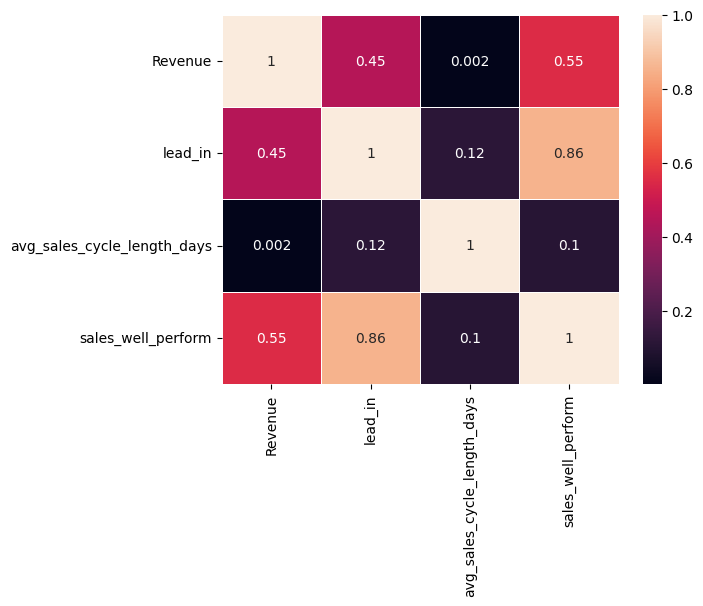

In [78]:
sns.heatmap(lead_with_opportunity_df.corr(method='spearman'),
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10})

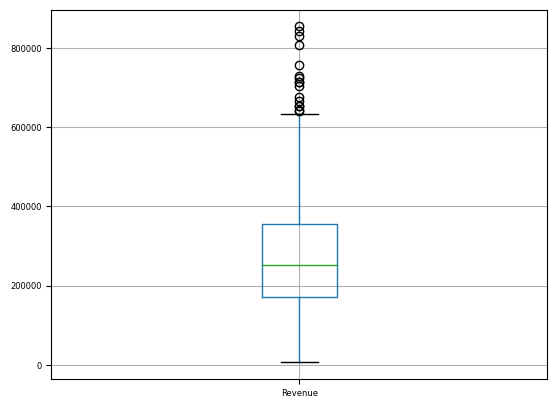

In [83]:
# Generate a boxplot
lead_with_opportunity_df[['Revenue']].boxplot(fontsize=6, vert=True)
plt.show()

In [67]:
lead_with_opportunity_df_oct23 = lead_with_opportunity_df.loc['2023-10']
print(lead_with_opportunity_df_oct23.head())


                          Revenue  lead_in  avg_sales_cycle_length_days  \
opportunity_close_date                                                    
2023-10-01               32000.00        1                          106   
2023-10-02                6000.00        3                           35   
2023-10-03               81800.00        3                           32   
2023-10-04              134709.91       89                           12   
2023-10-05              452310.00       91                           13   

                        sales_well_perform  
opportunity_close_date                      
2023-10-01                               1  
2023-10-02                               2  
2023-10-03                               1  
2023-10-04                              28  
2023-10-05                              29  


## Compare pct_change trend

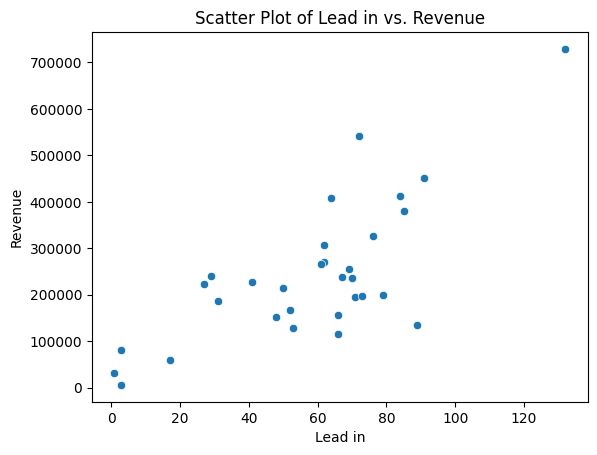

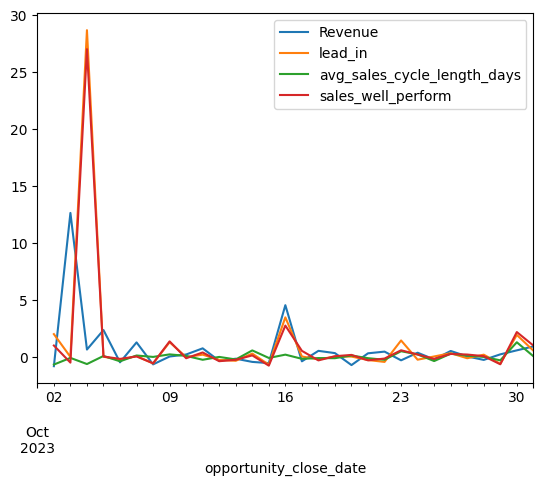

In [68]:
# Create a scatter plot
sns.scatterplot(x='lead_in', y='Revenue', data=lead_with_opportunity_df_oct23)

# Add labels and a title
plt.xlabel('Lead in')
plt.ylabel('Revenue')
plt.title('Scatter Plot of Lead in vs. Revenue')

# line plot
lead_with_opportunity_df_oct23.pct_change().plot()

# Show the plot
plt.show()

## Lagged 1 month

In [87]:
from pandas.tseries.frequencies import to_offset
predict_month = lead_with_opportunity_df.loc['2023-09']
predict_month.reset_index(inplace=True)
# predict_month['revenue_lagged_1_month'] = predict_month.Revenue.shift(periods=1)
predict_month['date_lagged_1_month'] = predict_month.opportunity_close_date - pd.offsets.DateOffset(months=1)
predict_month.head()

<ipython-input-87-b55f7550b0af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_month['date_lagged_1_month'] = predict_month.opportunity_close_date - pd.offsets.DateOffset(months=1)


,opportunity_close_date,Revenue,lead_in,avg_sales_cycle_length_days,sales_well_perform,date_lagged_1_month
0,2023-09-01,273900.0,54,7,35,2023-08-01
1,2023-09-02,302100.0,71,12,25,2023-08-02
2,2023-09-03,115700.0,18,5,9,2023-08-03
3,2023-09-04,262800.0,49,13,19,2023-08-04
4,2023-09-05,393070.0,99,16,32,2023-08-05


In [72]:
predict_month_with_lag.isna().sum()

opportunity_close_date_x         0
Revenue_x                        0
lead_in_x                        0
avg_sales_cycle_length_days_x    0
sales_well_perform_x             0
date_lagged_1_month              0
opportunity_close_date_y         0
Revenue_y                        0
lead_in_y                        0
avg_sales_cycle_length_days_y    0
sales_well_perform_y             0
dtype: int64

In [88]:
predict_month_with_lag = predict_month.merge(lead_with_opportunity_df, left_on='date_lagged_1_month', right_on='opportunity_close_date', how='left').fillna(0)
predict_month_with_lag.head()

,opportunity_close_date,Revenue_x,lead_in_x,avg_sales_cycle_length_days_x,sales_well_perform_x,date_lagged_1_month,Revenue_y,lead_in_y,avg_sales_cycle_length_days_y,sales_well_perform_y
0,2023-09-01,273900.0,54,7,35,2023-08-01,204300.0,91,18,37
1,2023-09-02,302100.0,71,12,25,2023-08-02,207510.0,54,10,24
2,2023-09-03,115700.0,18,5,9,2023-08-03,276050.0,58,14,26
3,2023-09-04,262800.0,49,13,19,2023-08-04,215110.0,40,10,16
4,2023-09-05,393070.0,99,16,32,2023-08-05,256040.0,54,7,26


## Fit model

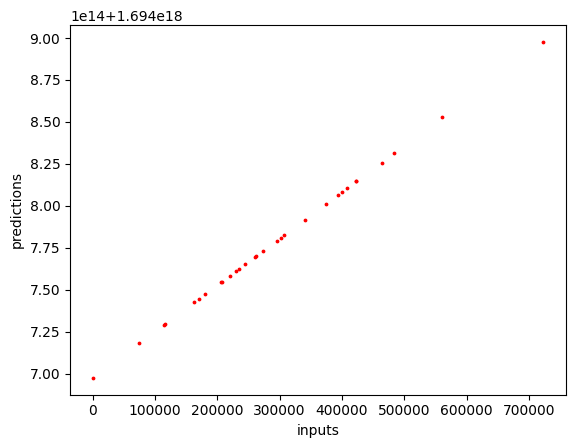

In [86]:
from sklearn.linear_model import LinearRegression

# Prepare input and output DataFrames
X = predict_month_with_lag[['Revenue_x']]
y = predict_month_with_lag[['opportunity_close_date']]

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Generate predictions with the model using the input data
predictions = model.predict(X)

# Visualize the inputs and predicted values
plt.scatter(X, predictions, color='r', s=3)
plt.xlabel('inputs')
plt.ylabel('predictions')
plt.show()